In [25]:
import wandb
api = wandb.Api()


In [26]:
from pathlib import Path
import json
import pandas as pd
import re

source_ts_amounts= [n * 2048 * 2 for n in [4, 6, 8]]
source_ts = 'data timesteps'
algo = 'algorithm'
algo_mapping = {
    "0sds7bw5": "CQL",
    "4mb6zgqq": "$\delta$ = 1",
    "i87w77ty": "$\delta$ = 2",
    "ft6049mq": "$\delta$ = $\delta_\max$",
}

def generate():
    for path in Path('artifacts').rglob('*.json'):
        pattern = r"run-(\w+)_(\w+)-tablereturns:v\d+"
        with path.open() as f:
            table = json.load(f)
        df = pd.DataFrame(table['data'], columns=table['columns'])
        match = re.search(pattern, str(path))
        df[algo] = algo_mapping[match.group(1)]
        id_within_sweep = int(match.group(2))
        df[source_ts] = source_ts_amounts[id_within_sweep]
        yield df
        
df = pd.concat(list(generate()), ignore_index=True)

x = 'timestep'
y = 'discounted returns'

df = df.rename(columns={'returns': y})
df.loc[:, x] = df.groupby(['idx', algo, source_ts, 'step'])[x].cumsum()
def keep_last_n_steps(group, n=10):
    steps = sorted(group['step'].unique())
    top_n = steps[-n:]
    return group[group['step'].isin(top_n)]

df = df.groupby([algo, source_ts], group_keys=False).apply(keep_last_n_steps)
df = df.sort_values(by=[algo, source_ts, 'step', 'idx', x])

bin_size = 20
df[x] = (df[x] // bin_size ) * bin_size
df = df[df[x] < 800]
df

,episode,idx,discounted returns,timestep,step,algorithm,data timesteps
26372,0,0,0.434231,80,12000,$\delta$ = $\delta_\max$,16384
26392,1,0,0.980100,180,12000,$\delta$ = $\delta_\max$,16384
26412,2,0,0.785678,280,12000,$\delta$ = $\delta_\max$,16384
26432,3,0,1.000000,380,12000,$\delta$ = $\delta_\max$,16384
26452,4,0,0.000000,480,12000,$\delta$ = $\delta_\max$,16384
...,...,...,...,...,...,...,...
5433,0,19,0.000000,80,45000,CQL,32768
5453,1,19,1.777821,180,45000,CQL,32768
5473,2,19,0.754511,280,45000,CQL,32768
5493,3,19,1.000000,380,45000,CQL,32768


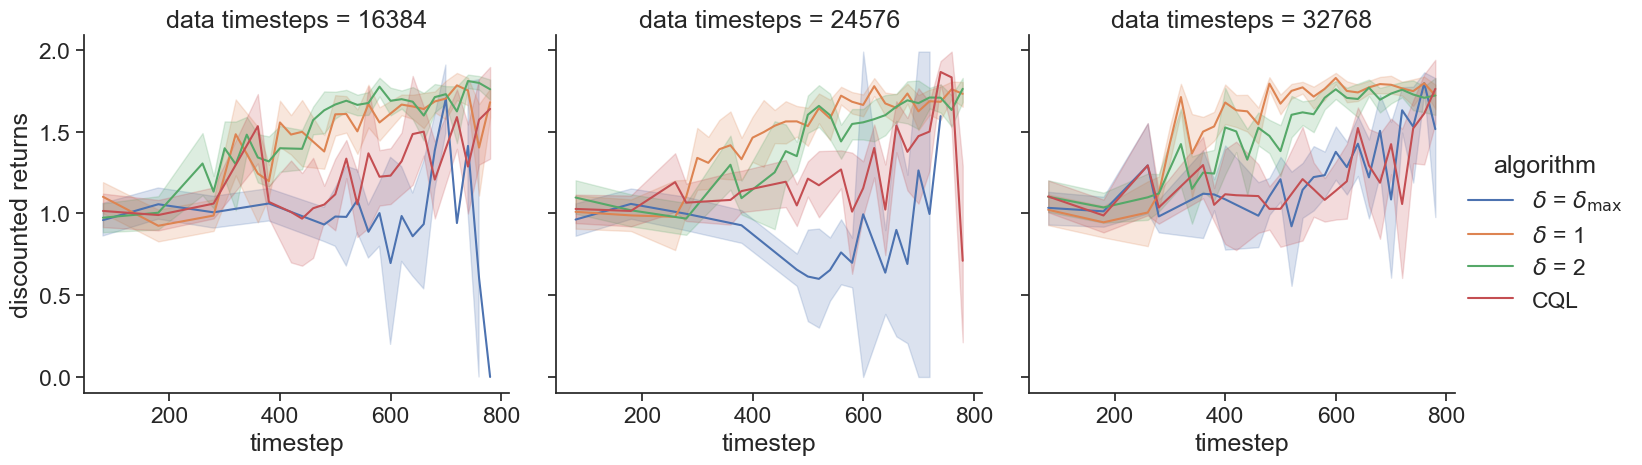

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.reset_defaults()
sns.set(font_scale=1.5)
sns.set_style('ticks')

g = sns.relplot(x=x, y=y, kind='line', hue=algo, data=df, col=source_ts)
plt.show()